In [1]:
import scipy.stats as stats
from sklearn.metrics import silhouette_score
from sklearn.compose import ColumnTransformer
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from datetime import datetime

In [2]:
data = pd.read_csv(r"C:\Users\ashka\OneDrive\Documents\DA 205 Segmentation\r_f_m.csv")
data.head()

user_id   birthdate gender  married  has_children home_country   home_city  \
0   465138  1986-12-15      F    False         False          usa  birmingham   
1   429375  1990-04-18      F    False         False          usa    new york   
2   429375  1990-04-18      F    False         False          usa    new york   
3   429375  1990-04-18      F    False         False          usa    new york   
4   429375  1990-04-18      F    False         False          usa    new york   

  home_airport  home_airport_lat  home_airport_lon  ...  \
0          BHM            33.563           -86.753  ...   
1          LGA            40.777           -73.872  ...   
2          LGA            40.777           -73.872  ...   
3          LGA            40.777           -73.872  ...   
4          LGA            40.777           -73.872  ...   

  discount_flight_proportion average_flight_discount  scaled_ads_per_km  \
0                        0.0                     NaN                NaN   
1                        0.0                     NaN                NaN   
2                        0.0                     NaN                NaN   
3                        0.0                     NaN                NaN   
4                        0.5                     NaN                NaN   

  repetitive recency frequency  total_page_clicks  r  f  p_c  
0         25     -71         9                180  5  5    5  
1         12    -109        10                301  5  5    5  
2         12    -109        10                301  5  5    5  
3         12    -109        10                301  5  5    5  
4         12    -109        10                301  5  5    5  

[5 rows x 55 columns]

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40993 entries, 0 to 40992
Data columns (total 55 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   user_id                     40993 non-null  int64  
 1   birthdate                   40993 non-null  object 
 2   gender                      40993 non-null  object 
 3   married                     40993 non-null  bool   
 4   has_children                40993 non-null  bool   
 5   home_country                40993 non-null  object 
 6   home_city                   40993 non-null  object 
 7   home_airport                40993 non-null  object 
 8   home_airport_lat            40993 non-null  float64
 9   home_airport_lon            40993 non-null  float64
 10  sign_up_date                40993 non-null  object 
 11  session_id                  40993 non-null  object 
 12  user_id.1                   40993 non-null  int64  
 13  trip_id                     409

In [4]:
data['recency'] = data['recency'] * -1

In [5]:
condition = data['session_start'] >= '2023-01-04'
filtered_df = data[condition]
data = filtered_df
date_columns = ['birthdate', 'sign_up_date','session_start', 'session_end', 
                'departure_time', 'return_time', 'check_in_time', 'check_out_time']

for col in date_columns:
    data[col] = pd.to_datetime(data[col], errors='coerce')

data['age_timedelta'] = data['session_end'].max() - data['birthdate']
data['age_years'] = data['age_timedelta'] // pd.Timedelta(days=365)  # Calculate age in years
data['age'] = data['age_years'].astype(int)
data['age'].describe()

count    38988.000000
mean        42.366267
std          7.822396
min         16.000000
25%         37.000000
50%         42.000000
75%         48.000000
max         83.000000
Name: age, dtype: float64

In [6]:
data.isna().sum()

user_id                           0
birthdate                         0
gender                            0
married                           0
has_children                      0
home_country                      0
home_city                         0
home_airport                      0
home_airport_lat                  0
home_airport_lon                  0
sign_up_date                      0
session_id                        0
user_id.1                         0
trip_id                           0
session_start                     0
session_end                     442
flight_discount                   0
hotel_discount                    0
flight_discount_amount        33732
hotel_discount_amount         34344
flight_booked                     0
hotel_booked                      0
page_clicks                       0
cancellation                      0
trip_id.1                         0
origin_airport                    0
destination                       0
destination_airport         

In [6]:
print(data.dtypes)

user_id                                 int64
birthdate                      datetime64[ns]
gender                                 object
married                                  bool
has_children                             bool
home_country                           object
home_city                              object
home_airport                           object
home_airport_lat                      float64
home_airport_lon                      float64
sign_up_date                   datetime64[ns]
session_id                             object
user_id.1                               int64
trip_id                                object
session_start                  datetime64[ns]
session_end                    datetime64[ns]
flight_discount                          bool
hotel_discount                           bool
flight_discount_amount                float64
hotel_discount_amount                 float64
flight_booked                            bool
hotel_booked                      

In [7]:
boolean_columns = ['married', 'has_children', 'flight_discount', 'hotel_discount', 'flight_booked', 'hotel_booked', 'return_flight_booked', 'cancellation', 'repetitive']

# Convert boolean columns to numeric (0s and 1s)
data[boolean_columns] = data[boolean_columns].astype(int)

In [8]:
data.drop(['trip_id.1', 'user_id.1', 'r', 'f', 'p_c'], axis=1, inplace=True)

In [9]:
print(data.session_start.min(), data['session_start'].max())

2023-01-04 00:01:00 2023-07-25 14:47:04


In [10]:
data.drop(['age_timedelta', 'age_years'], axis=1, inplace=True)
data.drop(['repetitive'], axis=1, inplace=True)
# Converting session_duration to total number of seconds
data['session_duration'] = data['session_end'] - data['session_start'] 
mean_session_duration = data['session_duration'].mean()
data['session_duration'].fillna(mean_session_duration, inplace=True)
data['session_duration'] = data['session_duration'].apply(lambda x: pd.Timedelta(x).total_seconds())
data.session_duration.describe()

count    38988.000000
mean       305.611166
std        831.226520
min        104.000000
25%        145.000000
50%        172.000000
75%        225.000000
max       7200.000000
Name: session_duration, dtype: float64

In [11]:
def vincenty_distance(lat1, lon1, lat2, lon2):
    a = 6378137.0  # Semi-major axis of the ellipsoid (WGS-84)
    f = 1 / 298.257223563  # Flattening of the ellipsoid (WGS-84)

    lat1_rad = np.radians(lat1)
    lon1_rad = np.radians(lon1)
    lat2_rad = np.radians(lat2)
    lon2_rad = np.radians(lon2)

    delta_lon = lon2_rad - lon1_rad

    U1 = np.arctan((1 - f) * np.tan(lat1_rad))
    U2 = np.arctan((1 - f) * np.tan(lat2_rad))

    sin_U1 = np.sin(U1)
    cos_U1 = np.cos(U1)
    sin_U2 = np.sin(U2)
    cos_U2 = np.cos(U2)

    lambda_L = delta_lon
    lambda_prev = 2 * np.pi

    iter_limit = 100

    while abs(lambda_L - lambda_prev) > 1e-12 and iter_limit > 0:
        sin_lambda = np.sin(lambda_L)
        cos_lambda = np.cos(lambda_L)
        sin_sigma = np.sqrt((cos_U2 * sin_lambda) ** 2 + (cos_U1 * sin_U2 - sin_U1 * cos_U2 * cos_lambda) ** 2)
        cos_sigma = sin_U1 * sin_U2 + cos_U1 * cos_U2 * cos_lambda
        sigma = np.arctan2(sin_sigma, cos_sigma)
        sin_alpha = cos_U1 * cos_U2 * sin_lambda / sin_sigma
        cos2_alpha = 1 - sin_alpha ** 2
        cos_2sigma_m = cos_sigma - 2 * sin_U1 * sin_U2 / cos2_alpha
        C = f / 16 * cos2_alpha * (4 + f * (4 - 3 * cos2_alpha))
        lambda_prev = lambda_L
        lambda_L = delta_lon + (1 - C) * f * sin_alpha * (
                sigma + C * sin_sigma * (cos_2sigma_m + C * cos_sigma * (-1 + 2 * cos_2sigma_m ** 2)))

        iter_limit -= 1

    u2 = cos2_alpha * ((a ** 2 - 6356752.3142 ** 2) / 6356752.3142 ** 2)
    A = 1 + u2 / 16384 * (4096 + u2 * (-768 + u2 * (320 - 175 * u2)))
    B = u2 / 1024 * (256 + u2 * (-128 + u2 * (74 - 47 * u2)))
    delta_sigma = B * sin_sigma * (
            cos_2sigma_m + B / 4 * (cos_sigma * (-1 + 2 * cos_2sigma_m ** 2) - B / 6 * cos_2sigma_m * (
            -3 + 4 * sin_sigma ** 2) * (-3 + 4 * cos_2sigma_m ** 2)))

    distance = 6356752.3142 * A * (sigma - delta_sigma) / 1000  # Convert to kilometers
    return distance

data['flight_distance'] = data.apply(lambda row: vincenty_distance(row['home_airport_lat'],
                                                                   row['home_airport_lon'],
                                                                   row['destination_airport_lat'],
                                                                   row['destination_airport_lon']),
                                     axis=1)

In [12]:
data.flight_distance.describe()

count    38988.000000
mean      2119.483129
std       1490.550953
min         17.685030
25%       1056.757071
50%       1990.523621
75%       2984.626597
max      16016.238118
Name: flight_distance, dtype: float64

In [13]:
# Filling missing values for discounts, checked bags, and fare with 0
data[['flight_discount_amount', 'hotel_discount_amount', 'average_flight_discount', 'scaled_ads_per_km']] = data[['flight_discount_amount', 'hotel_discount_amount', 'average_flight_discount', 'scaled_ads_per_km']].fillna(0)

In [14]:
# Select only the numeric columns
numeric_columns = data.select_dtypes(include=['number']).columns

# Convert the numeric_columns to a list
selected_columns = list(numeric_columns)

# Columns to exclude
columns_to_exclude = ['r', 'f', 'p_c']

# Remove excluded columns from the selected_columns list
selected_columns = [col for col in selected_columns if col not in columns_to_exclude]

In [15]:
# Mapping gender categories to numeric values (example mapping)
gender_mapping = {'M': 0, 'F': 1, 'O': 2}
data['gender'] = data['gender'].map(gender_mapping)

In [16]:
data[selected_columns].isna().sum()

user_id                       0
married                       0
has_children                  0
home_airport_lat              0
home_airport_lon              0
flight_discount               0
hotel_discount                0
flight_discount_amount        0
hotel_discount_amount         0
flight_booked                 0
hotel_booked                  0
page_clicks                   0
cancellation                  0
seats                         0
return_flight_booked          0
checked_bags                  0
destination_airport_lat       0
destination_airport_lon       0
base_fare_usd                 0
nights                        0
rooms                         0
hotel_per_room_usd            0
session_count                 0
discount_flight_proportion    0
average_flight_discount       0
scaled_ads_per_km             0
recency                       0
frequency                     0
total_page_clicks             0
age                           0
session_duration              0
flight_d

In [17]:
data.gender.value_counts()

gender
1    34393
0     4519
2       76
Name: count, dtype: int64

Missing Values:
user_id                       0
married                       0
has_children                  0
flight_discount               0
hotel_discount                0
flight_discount_amount        0
hotel_discount_amount         0
flight_booked                 0
hotel_booked                  0
page_clicks                   0
cancellation                  0
seats                         0
return_flight_booked          0
checked_bags                  0
base_fare_usd                 0
nights                        0
rooms                         0
hotel_per_room_usd            0
session_count                 0
discount_flight_proportion    0
average_flight_discount       0
scaled_ads_per_km             0
recency                       0
frequency                     0
total_page_clicks             0
age                           0
session_duration              0
flight_distance               0
gender                        0
dtype: int64

Summary Statistics:

Column: user_id
count

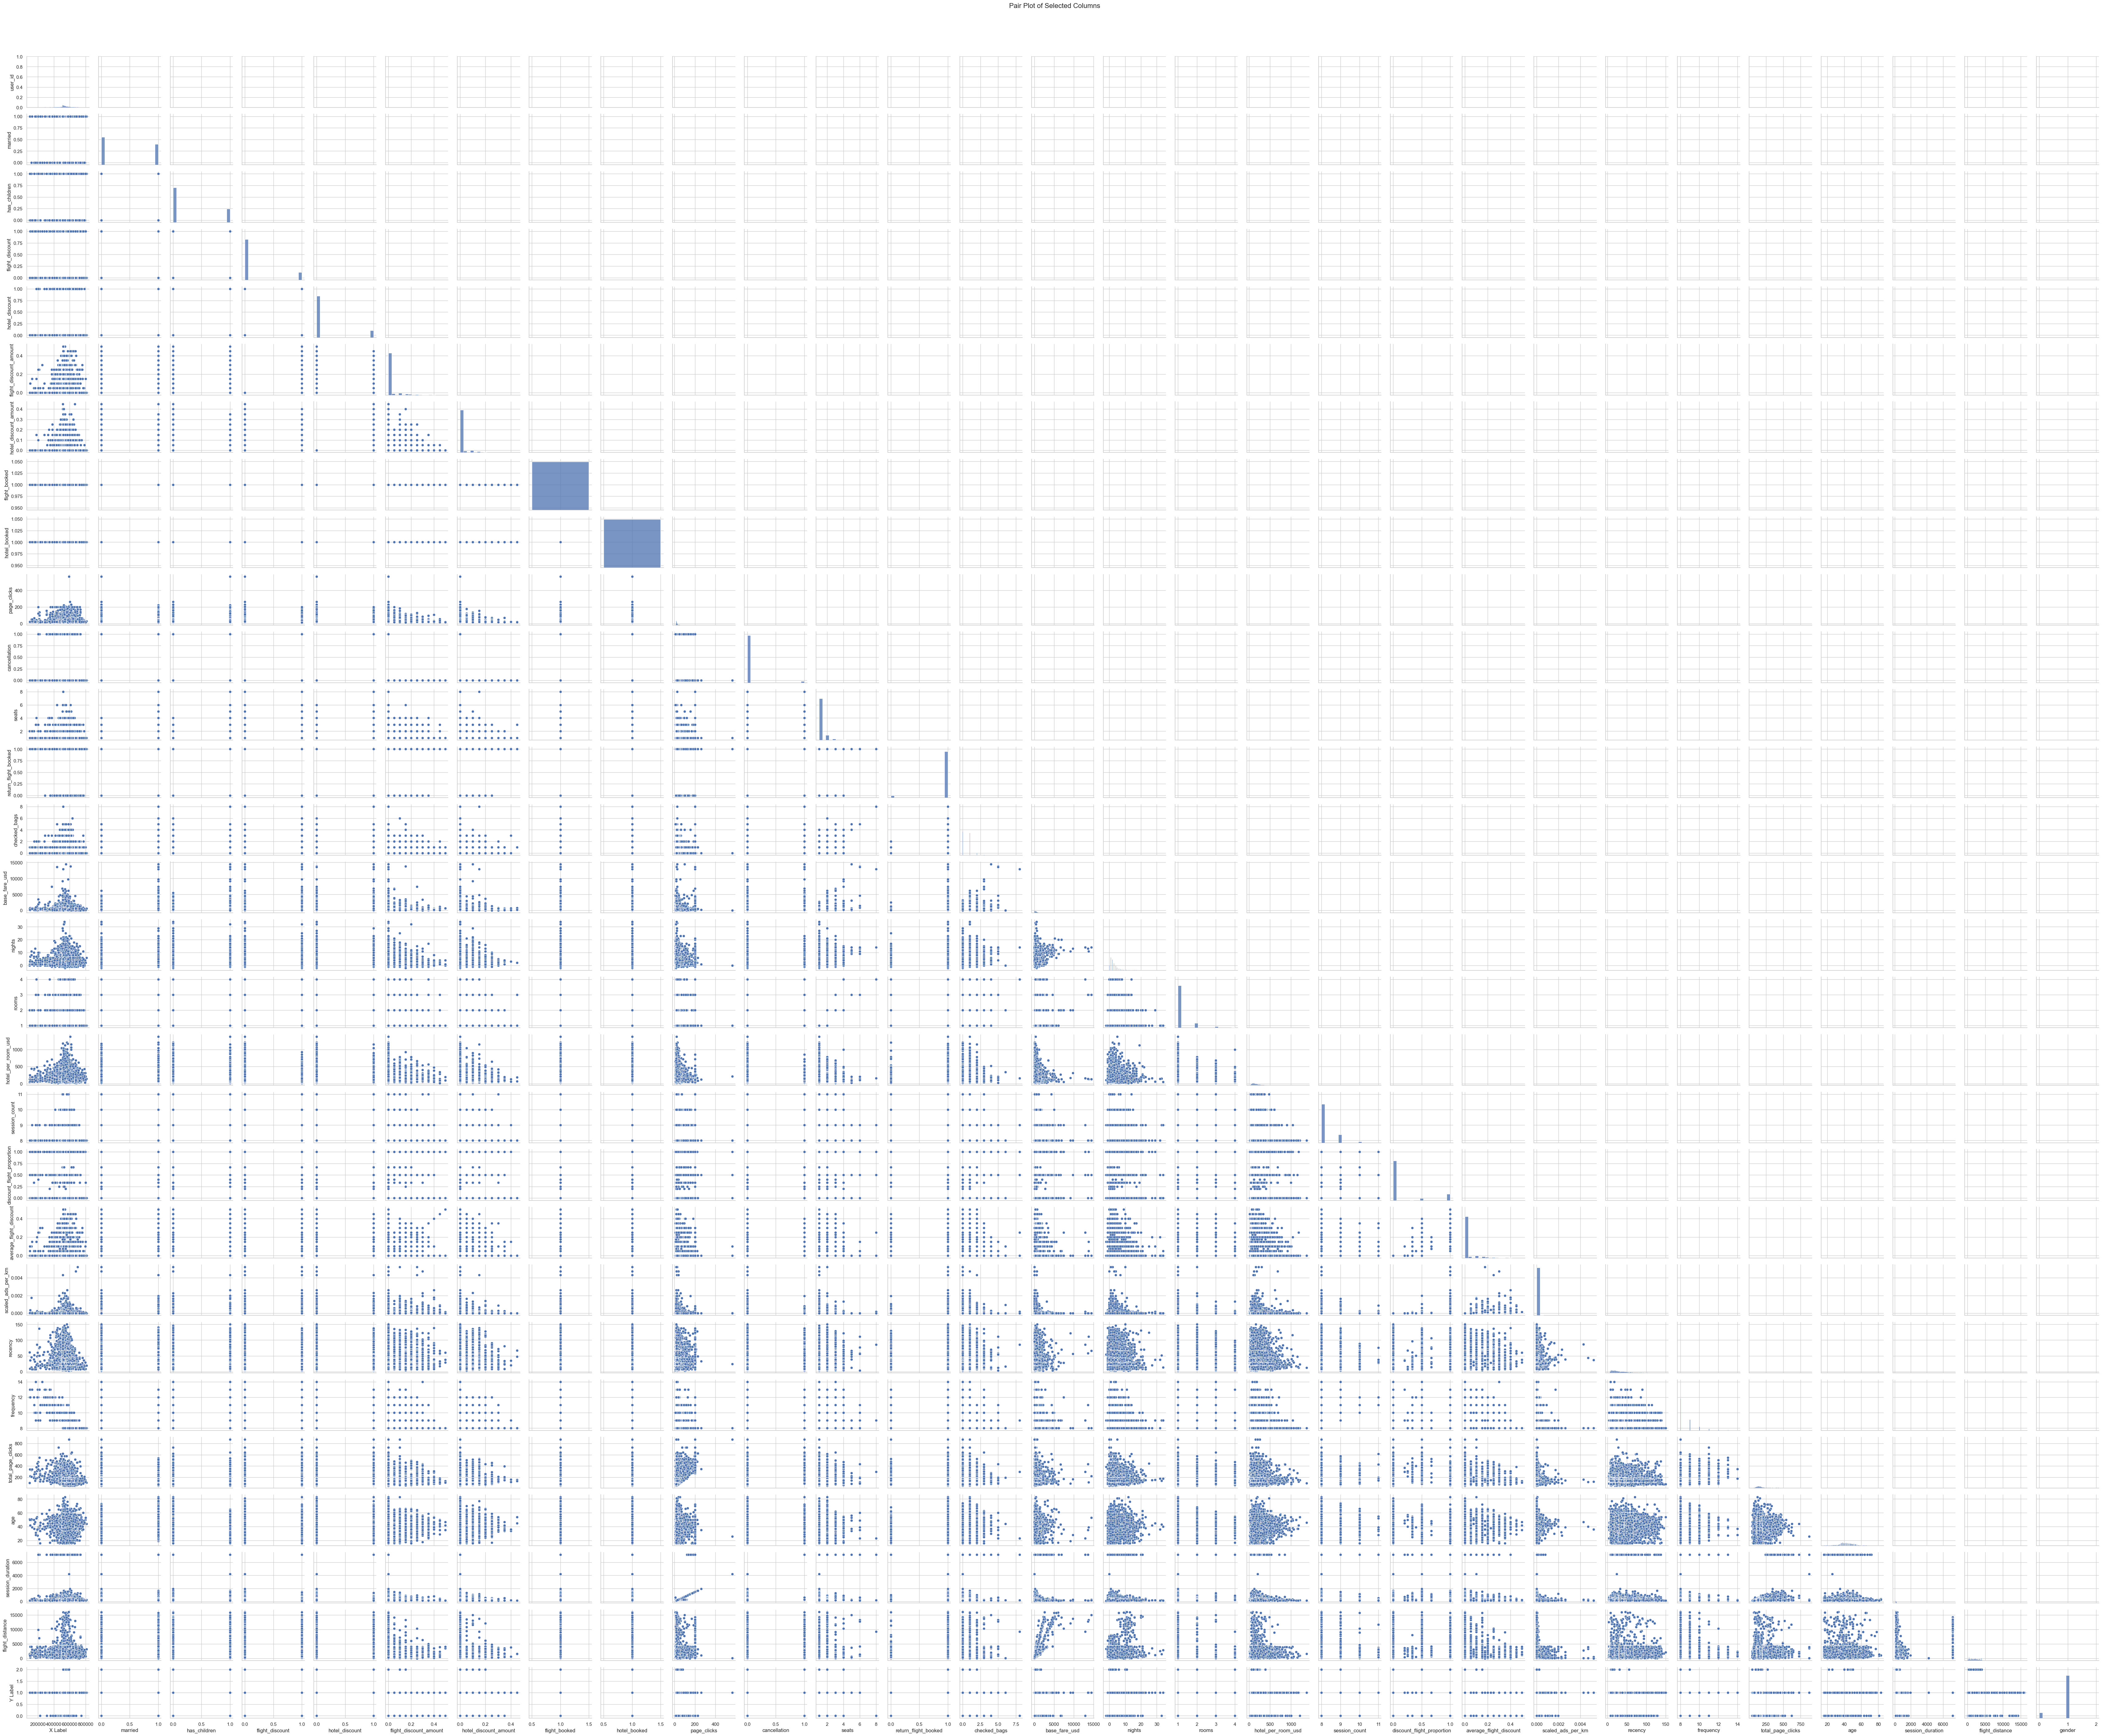

In [18]:
# List of selected columns
selected_columns = [
    'user_id', 'married', 'has_children',
    'flight_discount', 'hotel_discount', 'flight_discount_amount', 'hotel_discount_amount',
    'flight_booked', 'hotel_booked', 'page_clicks', 'cancellation', 'seats',
    'return_flight_booked', 'checked_bags',
    'base_fare_usd', 'nights', 'rooms', 'hotel_per_room_usd', 'session_count',
    'discount_flight_proportion', 'average_flight_discount', 'scaled_ads_per_km',
    'recency', 'frequency', 'total_page_clicks', 'age', 'session_duration',
    'flight_distance', 'gender'
]

# Copy the data and select the desired columns
data_copy = data.copy()
selected_data = data_copy[selected_columns]

# Check for missing values in the selected columns
missing_values = selected_data.isna().sum()

# Display the textual summary of missing values
print("Missing Values:")
print(missing_values)
print()

# Display summary statistics for each selected column
summary_stats = selected_data.describe()

# Print all summary statistics
print("Summary Statistics:")
for column in selected_columns:
    print(f"\nColumn: {column}")
    print(summary_stats[column])

# Configure Seaborn settings
sns.set(style="whitegrid")
# Increase the figure size and adjust font sizes
g = sns.PairGrid(selected_data, height=2, aspect=1.2)
g.map_lower(sns.scatterplot)
g.map_diag(sns.histplot, kde_kws={"color": "k"})
g.fig.subplots_adjust(top=0.95)

# Set larger font size for axis labels
g.axes[-1, 0].set_xlabel("X Label", fontsize=12)
g.axes[-1, 0].set_ylabel("Y Label", fontsize=12)

# Set larger font size for titles
g.fig.suptitle("Pair Plot of Selected Columns", fontsize=16)

# Show the pair plot
plt.show()

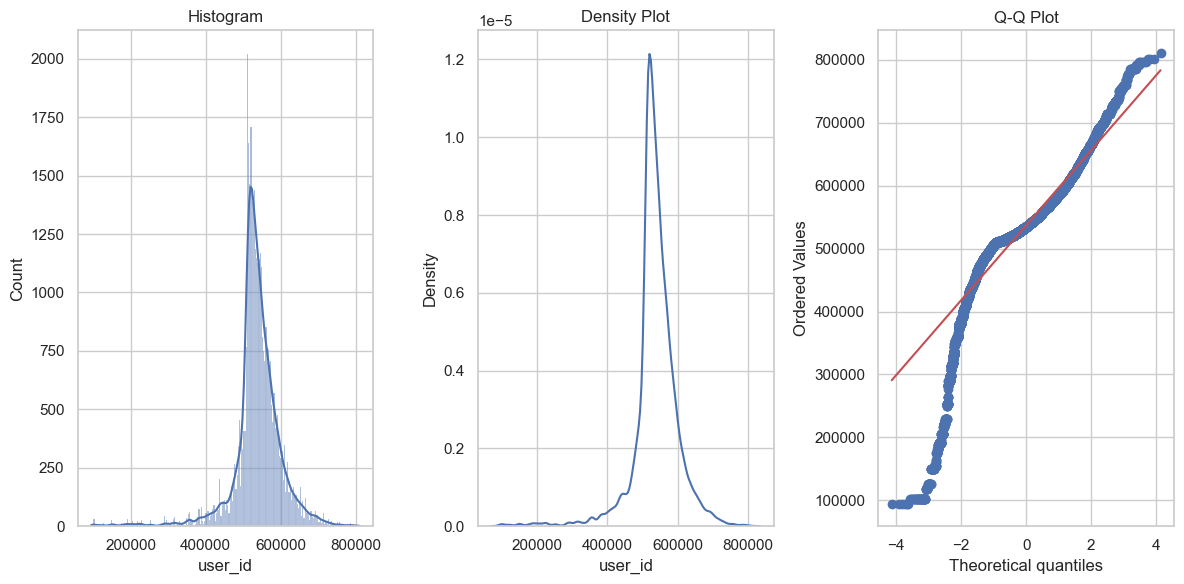

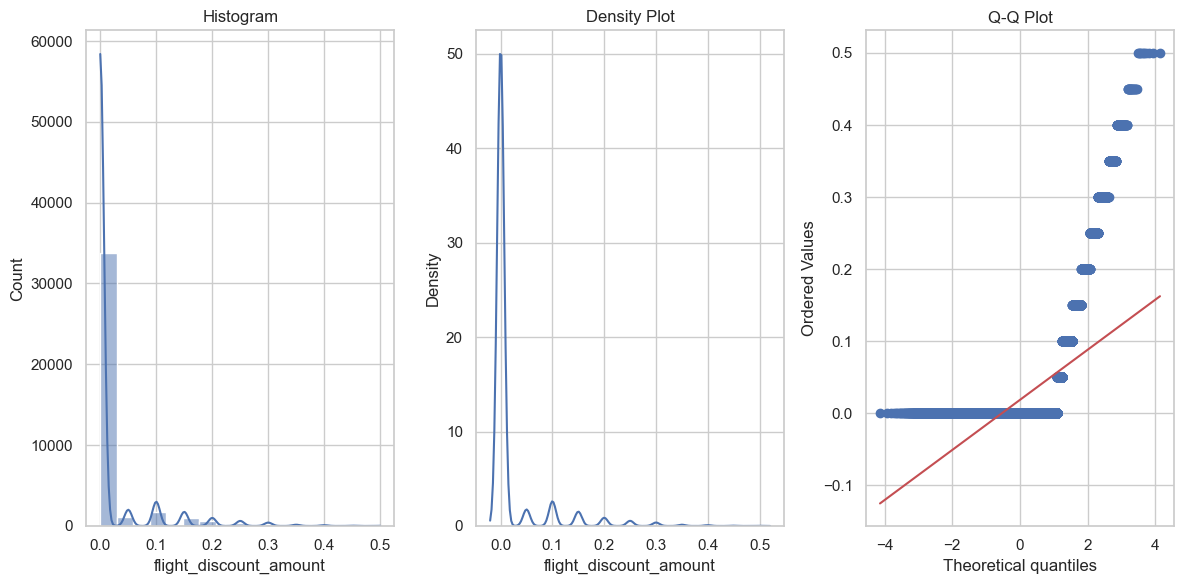

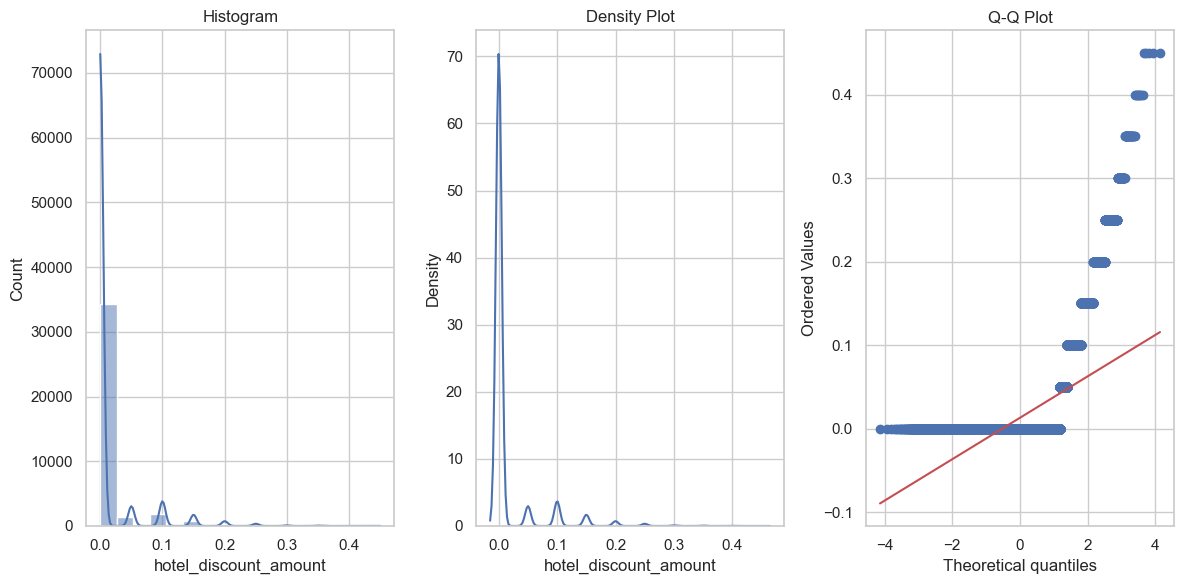

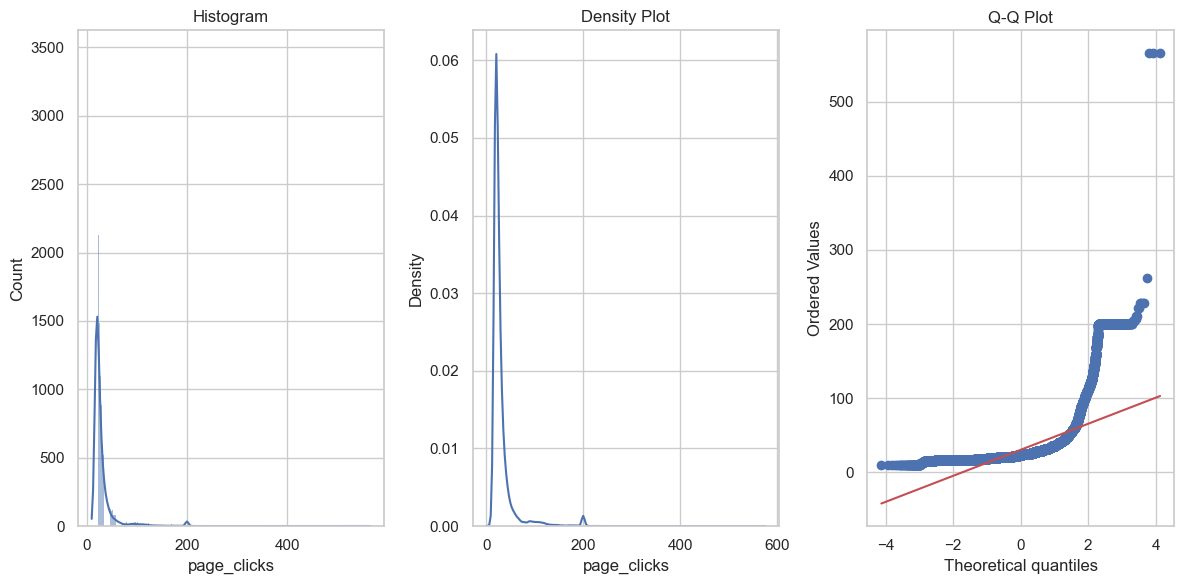

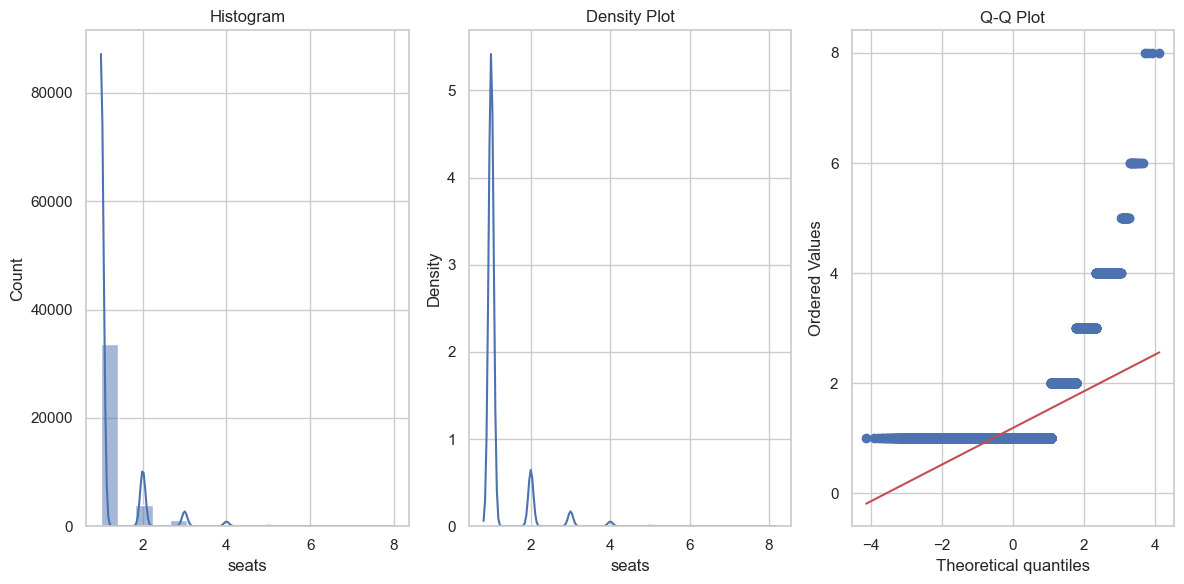

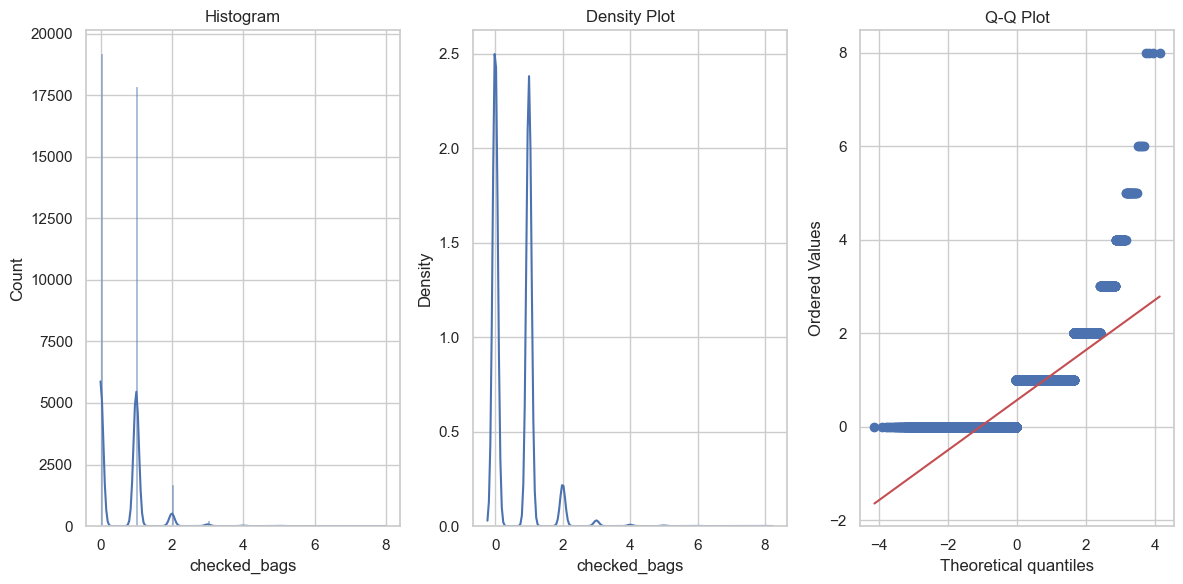

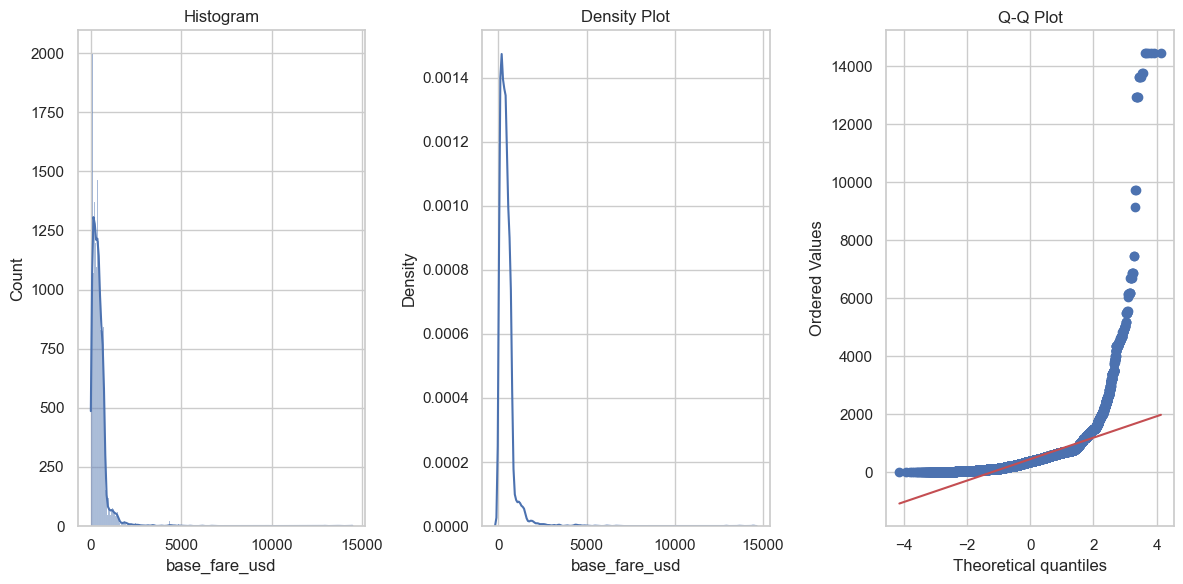

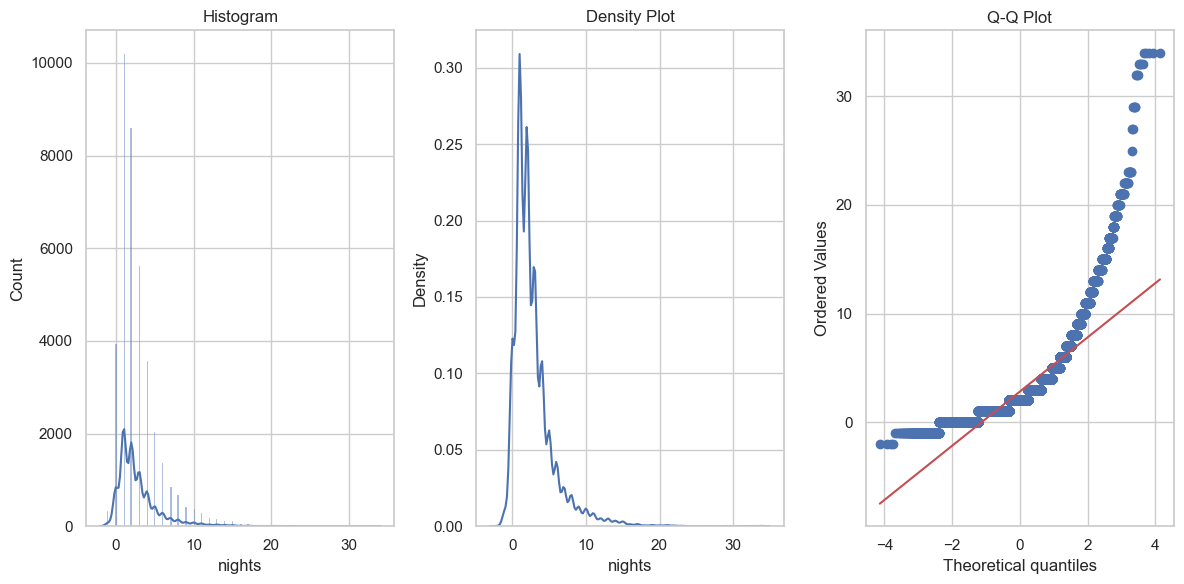

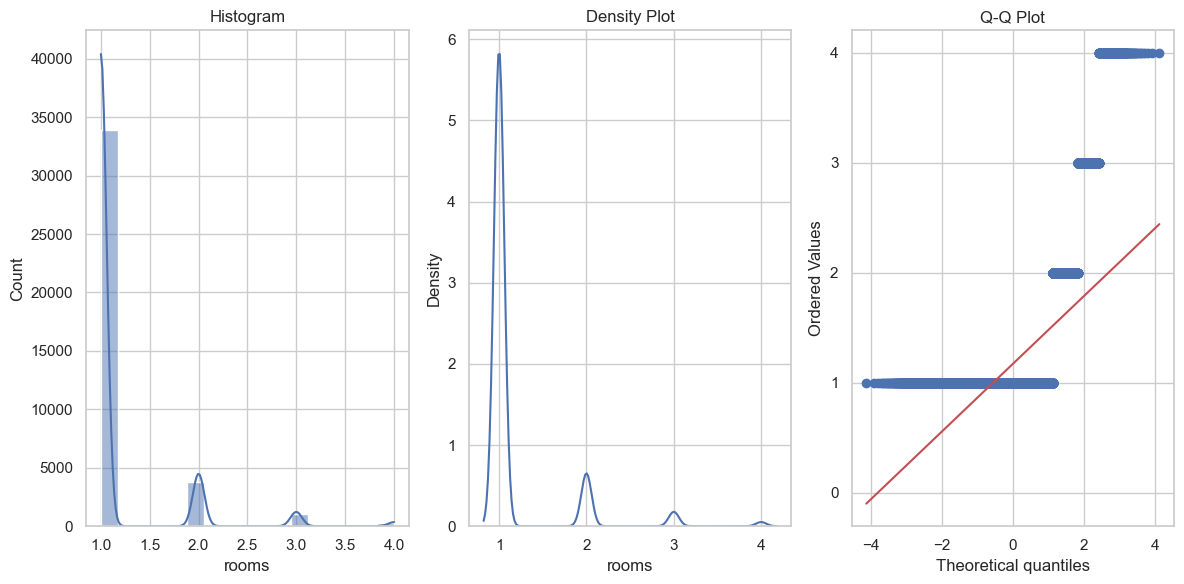

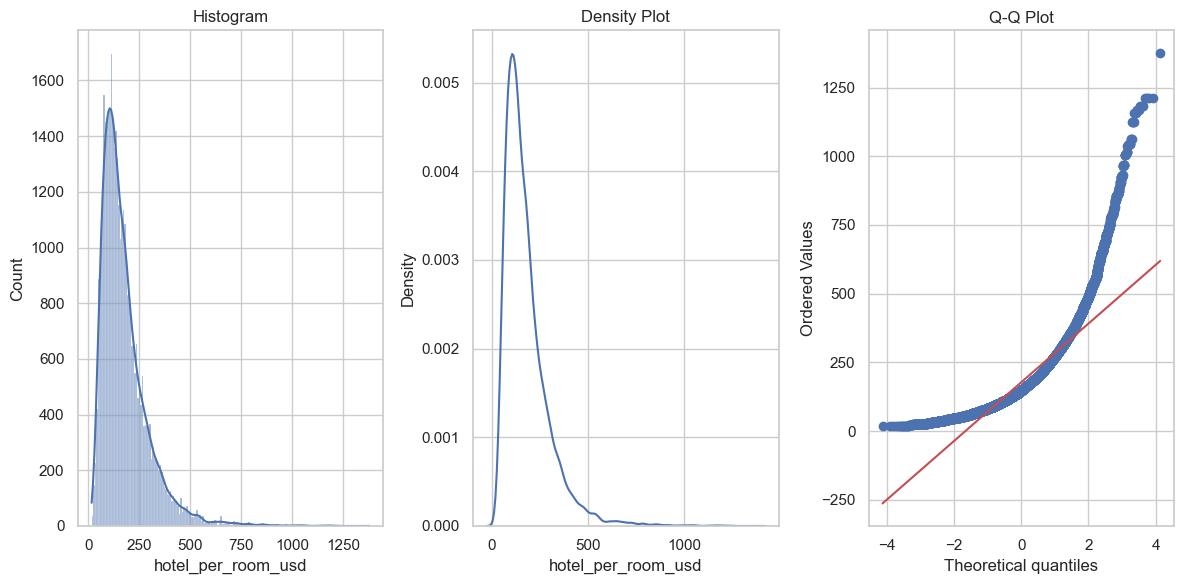

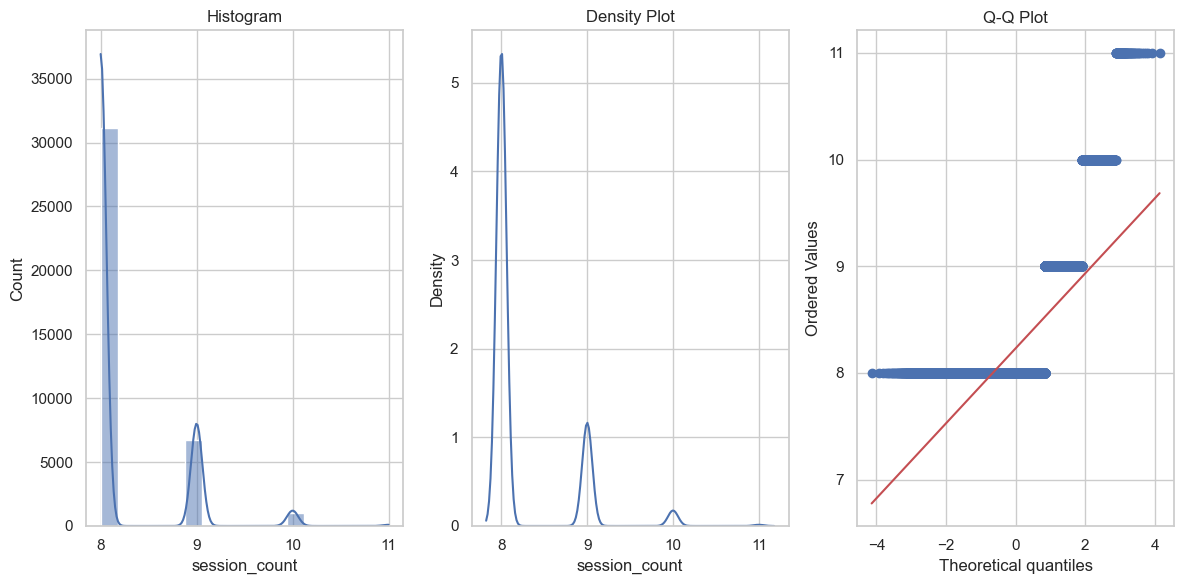

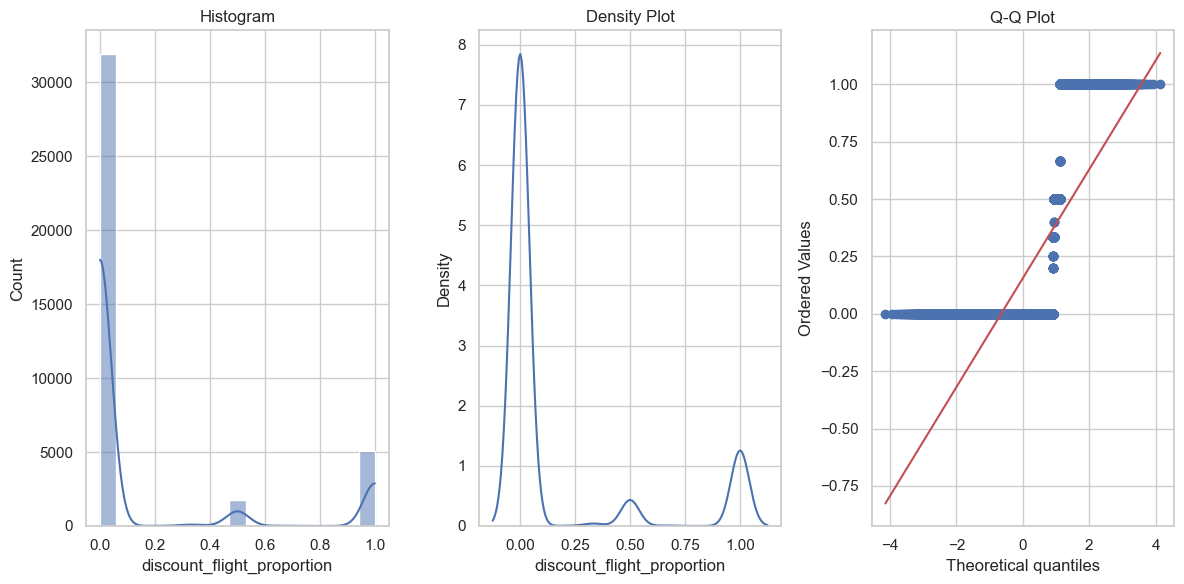

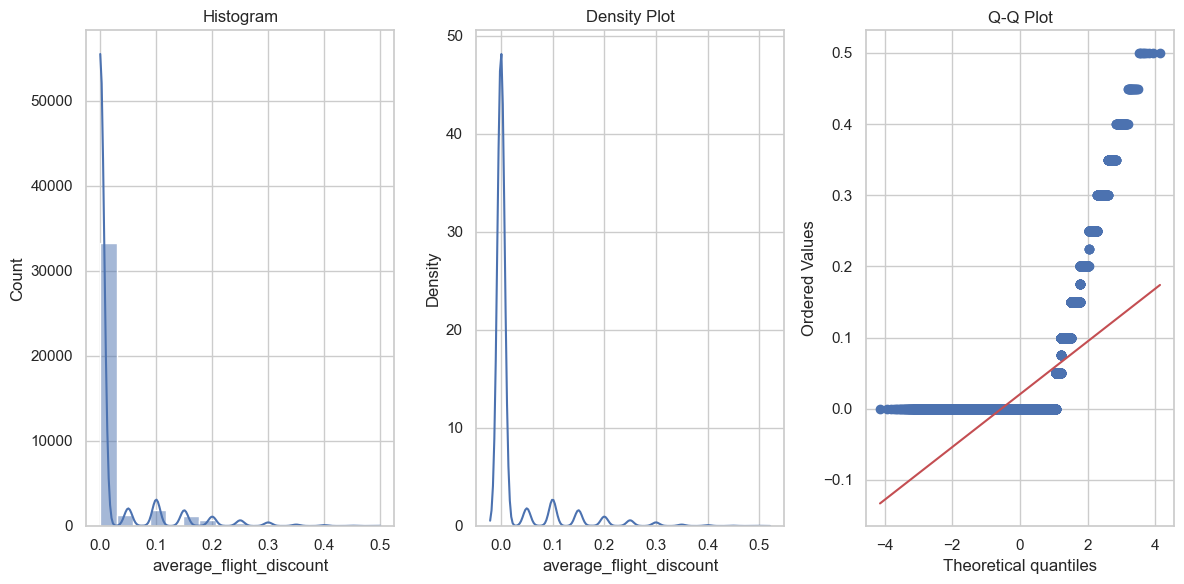

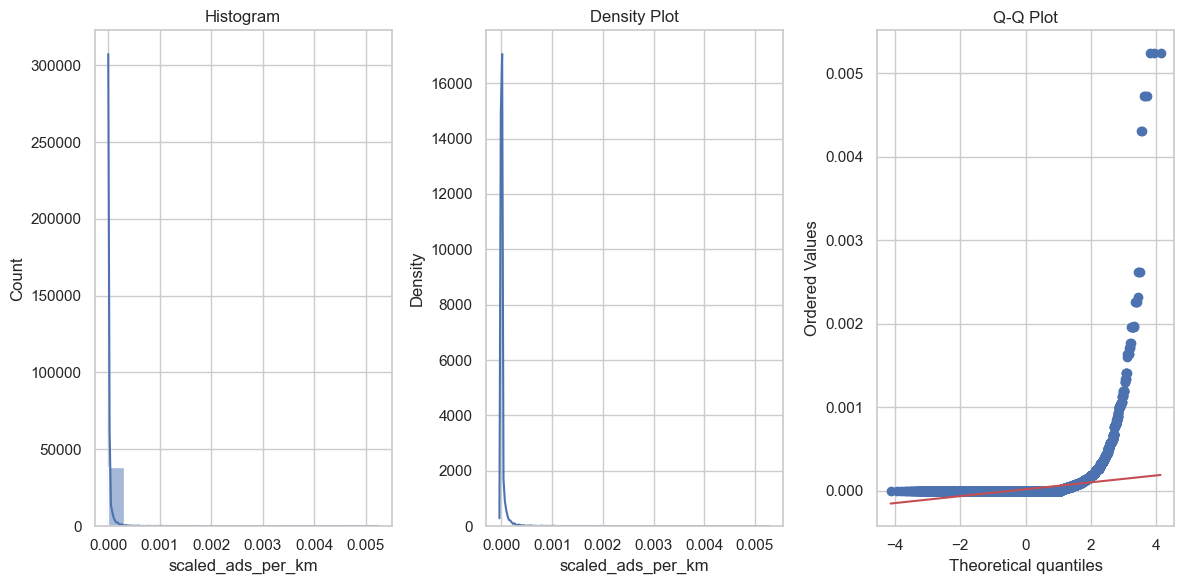

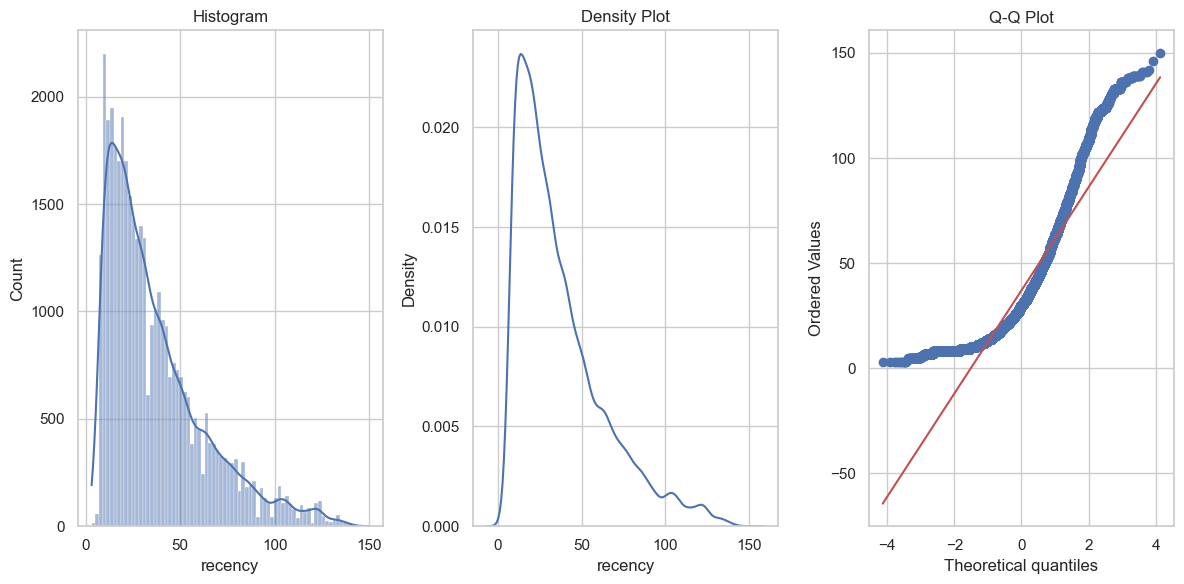

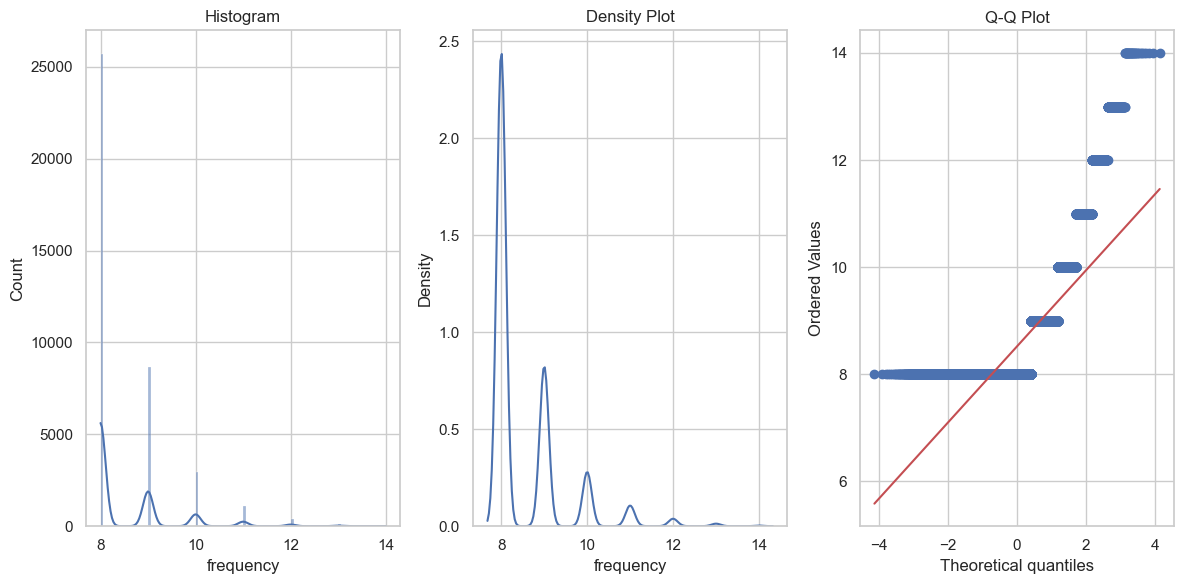

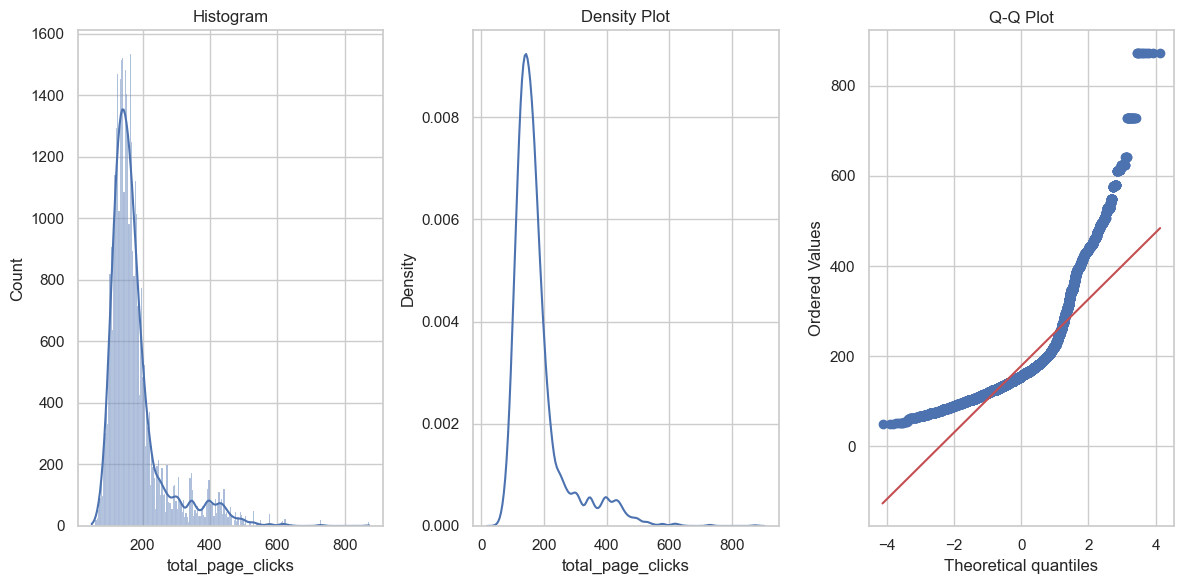

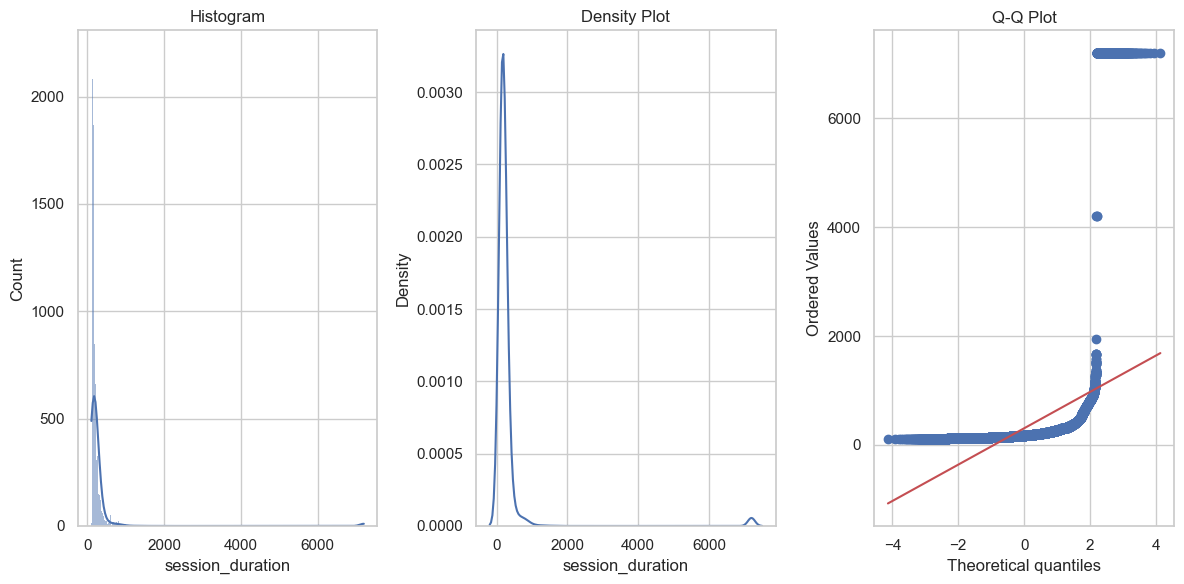

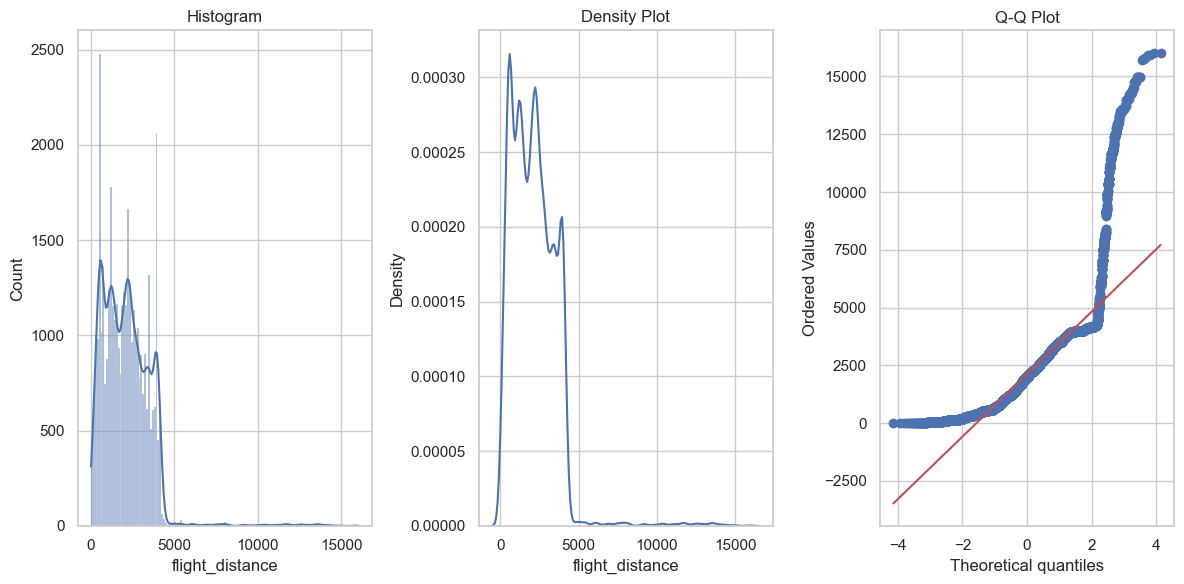

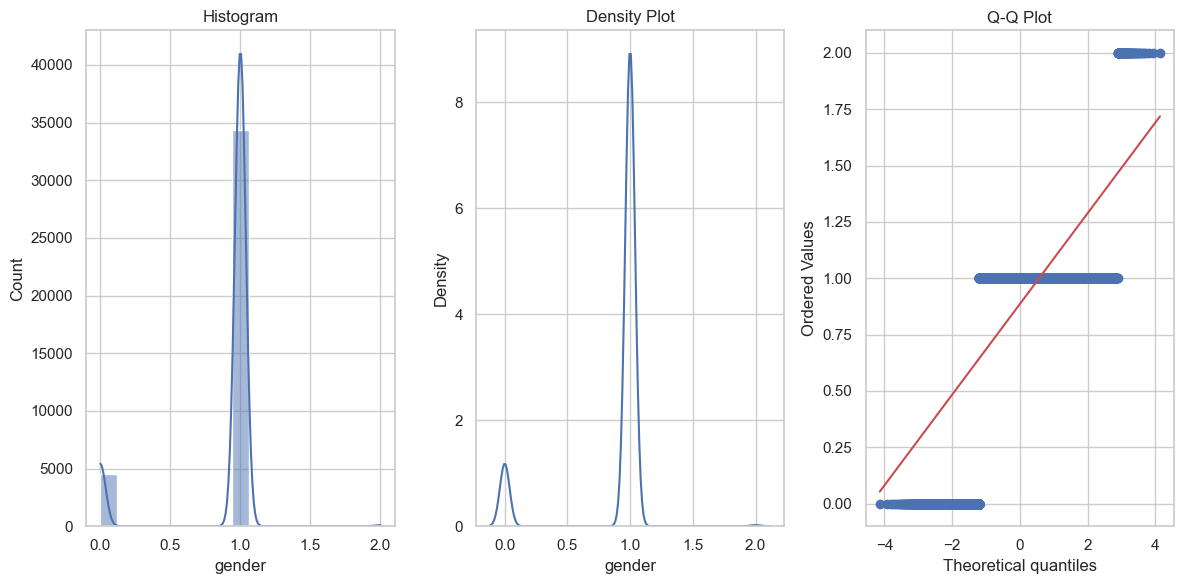

In [19]:
for column in selected_columns:
    if selected_data[column].dtype in ['int64', 'float64']:
        plt.figure(figsize=(12, 6))
        
        # Create histogram
        plt.subplot(1, 3, 1)
        sns.histplot(data=selected_data, x=column, kde=True)
        plt.title("Histogram")
        
        # Create density plot
        plt.subplot(1, 3, 2)
        sns.kdeplot(data=selected_data, x=column)
        plt.title("Density Plot")
        
        # Create Q-Q plot
        plt.subplot(1, 3, 3)
        stats.probplot(selected_data[column], dist="norm", plot=plt)
        plt.title("Q-Q Plot")
        
        # Adjust layout
        plt.tight_layout()
        plt.show()

In [20]:
# Copy the data and select the desired columns
data_copy = data.copy()
selected_data = data_copy[selected_columns]

# Standardize the selected data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(selected_data)

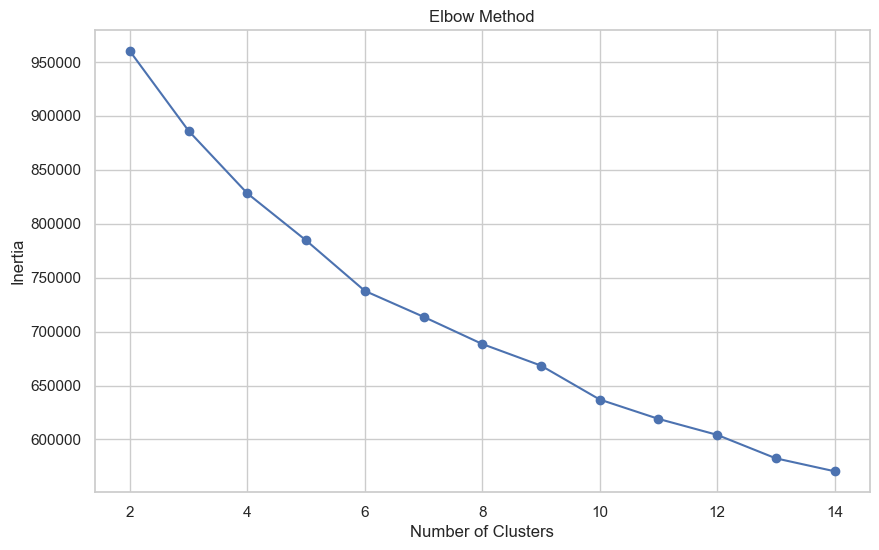

Number of Clusters: 2, Inertia: 959944.2741057356
Number of Clusters: 3, Inertia: 886022.1696268183
Number of Clusters: 4, Inertia: 828122.0190823121
Number of Clusters: 5, Inertia: 784549.8663163874
Number of Clusters: 6, Inertia: 737784.408910547
Number of Clusters: 7, Inertia: 713761.3853316854
Number of Clusters: 8, Inertia: 688533.005708569
Number of Clusters: 9, Inertia: 668505.6662050819
Number of Clusters: 10, Inertia: 637069.5619772514
Number of Clusters: 11, Inertia: 619125.3222055355
Number of Clusters: 12, Inertia: 604313.1720184677
Number of Clusters: 13, Inertia: 582542.2199356764
Number of Clusters: 14, Inertia: 570558.3209063105


In [27]:
# List of possible cluster numbers
cluster_range = range(2, 15)
inertias = []

for num_clusters in cluster_range:
    kmeans = KMeans(n_clusters=num_clusters, n_init=10, random_state=42)
    kmeans.fit(scaled_data)
    inertias.append(kmeans.inertia_)

# Plot the elbow curve
plt.figure(figsize=(10, 6))
plt.plot(cluster_range, inertias, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method')
plt.show()

for num_clusters in cluster_range:
    kmeans = KMeans(n_clusters=num_clusters, n_init=10, random_state=42)
    kmeans.fit(scaled_data)
    inertias.append(kmeans.inertia_)

# Print the inertia values for each cluster
for num_clusters, inertia in zip(cluster_range, inertias):
    print(f"Number of Clusters: {num_clusters}, Inertia: {inertia}")

Number of Clusters: 2, Silhouette Score: 0.4947
Number of Clusters: 3, Silhouette Score: 0.2113
Number of Clusters: 4, Silhouette Score: 0.1830
Number of Clusters: 5, Silhouette Score: 0.1128
Number of Clusters: 6, Silhouette Score: 0.1153
Number of Clusters: 7, Silhouette Score: 0.1207
Number of Clusters: 8, Silhouette Score: 0.0732
Number of Clusters: 9, Silhouette Score: 0.0752
Number of Clusters: 10, Silhouette Score: 0.0849
Number of Clusters: 11, Silhouette Score: 0.0879
Number of Clusters: 12, Silhouette Score: 0.0940
Number of Clusters: 13, Silhouette Score: 0.1028
Number of Clusters: 14, Silhouette Score: 0.0861


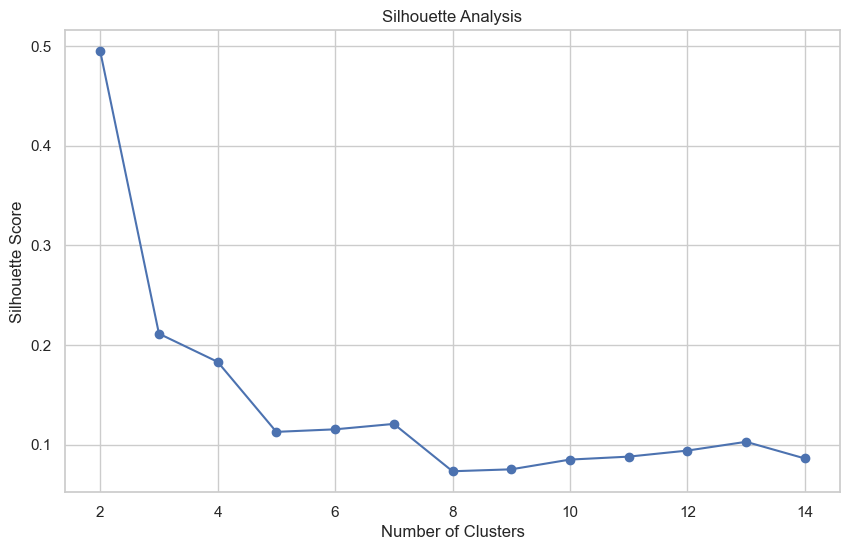

In [30]:
silhouette_scores = []

for num_clusters in cluster_range:
    kmeans = KMeans(n_clusters=num_clusters, n_init=10, random_state=42)
    cluster_labels = kmeans.fit_predict(scaled_data)
    silhouette_avg = silhouette_score(scaled_data, cluster_labels)
    silhouette_scores.append(silhouette_avg)
    print(f"Number of Clusters: {num_clusters}, Silhouette Score: {silhouette_avg:.4f}")

# Plot silhouette scores
plt.figure(figsize=(10, 6))
plt.plot(cluster_range, silhouette_scores, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Analysis')
plt.show()

In [31]:
# Remove converted boolean columns and rename selected_columns to numerical_features
numerical_features = [
    'user_id', 'flight_discount_amount', 'hotel_discount_amount',
    'page_clicks', 'seats', 'checked_bags', 'base_fare_usd',
    'nights', 'rooms', 'hotel_per_room_usd', 'session_count',
    'discount_flight_proportion', 'average_flight_discount', 'scaled_ads_per_km',
    'recency', 'frequency', 'total_page_clicks', 'age', 'session_duration',
    'flight_distance', 'gender'
]

# Extract numerical features from the data
numerical_data = data[numerical_features]

# Standardize the numerical data
scaler = StandardScaler()
scaled_numerical_data = scaler.fit_transform(numerical_data)

In [33]:
# Elbow Method: Obtain inertia for different numbers of clusters
cluster_range = range(2, 15)
inertias = []

for num_clusters in cluster_range:
    kmeans = KMeans(n_clusters=num_clusters, n_init=10, random_state=42)
    kmeans.fit(scaled_numerical_data)
    inertias.append(kmeans.inertia_)

# Silhouette Analysis: Obtain silhouette scores for different numbers of clusters
silhouette_scores = []

for num_clusters in cluster_range:
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(scaled_numerical_data)
    silhouette_avg = silhouette_score(scaled_numerical_data, cluster_labels)
    silhouette_scores.append(silhouette_avg)

# Print Elbow and Silhouette scores
for num_clusters, inertia, silhouette_score in zip(cluster_range, inertias, silhouette_scores):
    print(f"Number of Clusters: {num_clusters}, Inertia: {inertia:.2f}, Silhouette Score: {silhouette_score:.4f}")


C:\Users\ashka\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\ashka\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\ashka\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\ashka\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of

Number of Clusters: 2, Inertia: 746822.49, Silhouette Score: 0.2318
Number of Clusters: 3, Inertia: 684476.85, Silhouette Score: 0.2305
Number of Clusters: 4, Inertia: 622351.99, Silhouette Score: 0.2393
Number of Clusters: 5, Inertia: 580098.83, Silhouette Score: 0.1468
Number of Clusters: 6, Inertia: 554040.65, Silhouette Score: 0.1512
Number of Clusters: 7, Inertia: 532233.62, Silhouette Score: 0.1521
Number of Clusters: 8, Inertia: 511832.95, Silhouette Score: 0.1502
Number of Clusters: 9, Inertia: 487927.30, Silhouette Score: 0.1573
Number of Clusters: 10, Inertia: 475711.98, Silhouette Score: 0.1182
Number of Clusters: 11, Inertia: 455936.62, Silhouette Score: 0.1223
Number of Clusters: 12, Inertia: 442938.13, Silhouette Score: 0.1250
Number of Clusters: 13, Inertia: 434044.27, Silhouette Score: 0.1515
Number of Clusters: 14, Inertia: 423994.47, Silhouette Score: 0.1224


Elbow Method: There seems to be a slight elbow around 4 clusters. This could be a reasonable choice as it's where the rate of inertia decrease changes.
Silhouette Score: The silhouette scores are relatively consistent, suggesting that the data might not have well-defined clusters.

In [40]:
# List of numerical features
numerical_features = [
    'flight_discount_amount', 'hotel_discount_amount',
    'page_clicks', 'seats', 'checked_bags', 'base_fare_usd',
    'nights', 'rooms', 'hotel_per_room_usd', 'session_count',
    'discount_flight_proportion', 'average_flight_discount', 'scaled_ads_per_km',
    'recency', 'frequency', 'total_page_clicks', 'age', 'session_duration',
    'flight_distance', 'gender'
]

# Create a copy of the data for outlier removal
data_copy = data.copy()

# Calculate Z-scores for each numerical feature
z_scores = ((data_copy[numerical_features] - data_copy[numerical_features].mean()) / data_copy[numerical_features].std()).abs()

# Set Z-score threshold for outlier removal (e.g., 3)
z_score_threshold = 3

# Remove rows with any Z-score above the threshold
outlier_indices = z_scores.apply(lambda row: any(row > z_score_threshold), axis=1)
data_copy = data_copy[~outlier_indices]

# Standardize the numerical features
scaler = StandardScaler()
scaled_numerical_data = scaler.fit_transform(data_copy[numerical_features])

# Elbow Method: Obtain inertia for different numbers of clusters
cluster_range = range(2, 15)
inertias = []

for num_clusters in cluster_range:
    kmeans = KMeans(n_clusters=num_clusters, n_init=10, random_state=42)
    kmeans.fit(scaled_numerical_data)
    inertias.append(kmeans.inertia_)

# Silhouette Analysis: Obtain silhouette scores for different numbers of clusters
silhouette_scores = []

for num_clusters in cluster_range:
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(scaled_numerical_data)
    silhouette_avg = silhouette_score(scaled_numerical_data, cluster_labels)
    silhouette_scores.append(silhouette_avg)

# Print Elbow and Silhouette scores
for num_clusters, inertia, silhouette_score in zip(cluster_range, inertias, silhouette_scores):
    print(f"Number of Clusters: {num_clusters}, Inertia: {inertia:.2f}, Silhouette Score: {silhouette_score:.4f}")


C:\Users\ashka\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\ashka\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\ashka\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\ashka\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of

Number of Clusters: 2, Inertia: 520350.27, Silhouette Score: 0.2632
Number of Clusters: 3, Inertia: 456484.98, Silhouette Score: 0.2846
Number of Clusters: 4, Inertia: 423280.07, Silhouette Score: 0.1607
Number of Clusters: 5, Inertia: 394011.89, Silhouette Score: 0.1604
Number of Clusters: 6, Inertia: 373675.89, Silhouette Score: 0.1121
Number of Clusters: 7, Inertia: 356942.20, Silhouette Score: 0.1157
Number of Clusters: 8, Inertia: 346994.04, Silhouette Score: 0.1181
Number of Clusters: 9, Inertia: 333718.45, Silhouette Score: 0.1045
Number of Clusters: 10, Inertia: 330053.61, Silhouette Score: 0.1107
Number of Clusters: 11, Inertia: 319480.53, Silhouette Score: 0.1063
Number of Clusters: 12, Inertia: 310858.00, Silhouette Score: 0.1179
Number of Clusters: 13, Inertia: 302095.31, Silhouette Score: 0.1092
Number of Clusters: 14, Inertia: 302991.91, Silhouette Score: 0.0974


In [41]:
# List of numerical features (same as before)
numerical_features = [
    'flight_discount_amount', 'hotel_discount_amount',
    'page_clicks', 'seats', 'checked_bags', 'base_fare_usd',
    'nights', 'rooms', 'hotel_per_room_usd', 'session_count',
    'discount_flight_proportion', 'average_flight_discount', 'scaled_ads_per_km',
    'recency', 'frequency', 'total_page_clicks', 'age', 'session_duration',
    'flight_distance', 'gender'
]

# Create a copy of the data for outlier removal
data_copy = data.copy()

# Calculate Z-scores for each numerical feature
z_scores = ((data_copy[numerical_features] - data_copy[numerical_features].mean()) / data_copy[numerical_features].std()).abs()

# Set Z-score threshold for outlier removal (e.g., 3)
z_score_threshold = 3

# Remove rows with any Z-score above the threshold
outlier_indices = z_scores.apply(lambda row: any(row > z_score_threshold), axis=1)
data_copy = data_copy[~outlier_indices]

# Extract numerical features from the data
numerical_data = data_copy[numerical_features]

# Perform KMeans clustering with 3 clusters
num_clusters_3 = 3
kmeans_3 = KMeans(n_clusters=num_clusters_3, random_state=42)
cluster_labels_3 = kmeans_3.fit_predict(numerical_data)

# Print cluster centers and sizes
cluster_centers_3 = kmeans_3.cluster_centers_
cluster_sizes_3 = pd.Series(cluster_labels_3).value_counts().sort_index()
print("Cluster Centers (3 Clusters):\n", cluster_centers_3)
print("\nCluster Sizes (3 Clusters):\n", cluster_sizes_3)


Cluster Centers (3 Clusters):
 [[1.00008715e-02 6.60188252e-03 2.68597699e+01 1.09421300e+00
  5.42966707e-01 1.56163767e+02 2.51525187e+00 1.09281855e+00
  1.70829963e+02 8.18363256e+00 1.09203416e-01 1.04104933e-02
  8.98903611e-06 3.58241241e+01 8.43315322e+00 1.66119575e+02
  4.23118355e+01 1.99763369e+02 8.23761362e+02 8.87310441e-01]
 [1.07815057e-02 6.90807420e-03 2.63241953e+01 1.10515548e+00
  5.50463721e-01 6.94288265e+02 2.45908347e+00 1.10474632e+00
  1.67389525e+02 8.17171304e+00 1.14884524e-01 1.09110747e-02
  5.59639971e-06 3.63513366e+01 8.39129842e+00 1.63369749e+02
  4.24787234e+01 1.95413386e+02 3.62979855e+03 8.83387889e-01]
 [1.00232311e-02 6.83380118e-03 2.65767109e+01 1.09737683e+00
  5.55996515e-01 4.24729804e+02 2.61842997e+00 1.09563450e+00
  1.68162424e+02 8.18207337e+00 1.14038654e-01 1.08895557e-02
  6.34346885e-06 3.54224180e+01 8.40896331e+00 1.65175394e+02
  4.25830026e+01 1.97375198e+02 2.23406874e+03 8.85296680e-01]]

Cluster Sizes (3 Clusters):
 0    

C:\Users\ashka\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [42]:
# Perform KMeans clustering with 4 clusters
num_clusters_4 = 4
kmeans_4 = KMeans(n_clusters=num_clusters_4, random_state=42)
cluster_labels_4 = kmeans_4.fit_predict(numerical_data)

# Print cluster centers and sizes
cluster_centers_4 = kmeans_4.cluster_centers_
cluster_sizes_4 = pd.Series(cluster_labels_4).value_counts().sort_index()
print("Cluster Centers (4 Clusters):\n", cluster_centers_4)
print("\nCluster Sizes (4 Clusters):\n", cluster_sizes_4)

Cluster Centers (4 Clusters):
 [[1.13229879e-02 6.89768543e-03 2.71011310e+01 1.09100473e+00
  5.62072593e-01 2.83663698e+02 2.58692793e+00 1.08798001e+00
  1.70301683e+02 8.18437664e+00 1.14647992e-01 1.09218832e-02
  7.11574573e-06 3.54952656e+01 8.41136244e+00 1.65560100e+02
  4.24617307e+01 2.00842627e+02 1.49754171e+03 8.96501841e-01]
 [1.09494640e-02 6.85298622e-03 2.62785605e+01 1.10535988e+00
  5.57120980e-01 7.08757406e+02 2.44915773e+00 1.10490046e+00
  1.67752221e+02 8.16952527e+00 1.16819806e-01 1.11370597e-02
  5.73812551e-06 3.66277182e+01 8.39142420e+00 1.63534456e+02
  4.24926493e+01 1.95104994e+02 3.70514960e+03 8.89892802e-01]
 [9.03265812e-03 6.57296403e-03 2.66975334e+01 1.09797437e+00
  5.40305912e-01 1.08209986e+02 2.51605347e+00 1.09687199e+00
  1.70239768e+02 8.17665702e+00 1.07264251e-01 1.01626016e-02
  9.74796337e-06 3.54749897e+01 8.43998898e+00 1.66778972e+02
  4.22666391e+01 1.99002205e+02 5.68072857e+02 8.79564558e-01]
 [9.57913762e-03 6.72605216e-03 2.63

C:\Users\ashka\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


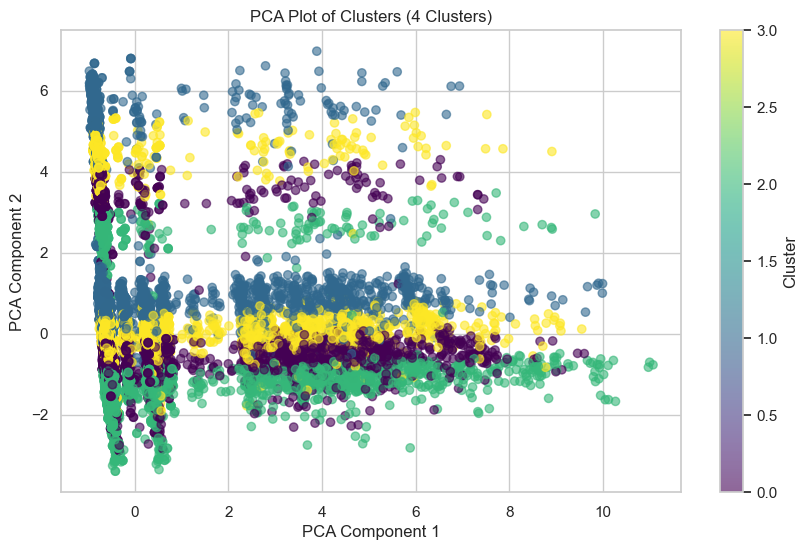

In [43]:
# Standardize the numerical data for PCA
scaler = StandardScaler()
scaled_numerical_data = scaler.fit_transform(numerical_data)

# Apply PCA to reduce dimensionality
pca = PCA(n_components=2)
pca_components = pca.fit_transform(scaled_numerical_data)

# Create a DataFrame with PCA components and cluster labels
pca_df = pd.DataFrame({'PCA1': pca_components[:, 0], 'PCA2': pca_components[:, 1], 'Cluster': cluster_labels_4})

# Plot clusters in PCA space
plt.figure(figsize=(10, 6))
plt.scatter(pca_df['PCA1'], pca_df['PCA2'], c=pca_df['Cluster'], cmap='viridis', alpha=0.6)
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('PCA Plot of Clusters (4 Clusters)')
plt.colorbar(label='Cluster')
plt.show()

In [44]:
# Fit PCA to the scaled numerical data
pca = PCA(n_components=2)  # You can adjust the number of components as needed
pca_result = pca.fit_transform(scaled_numerical_data)

# Create a DataFrame for the PCA results
pca_df = pd.DataFrame(data=pca_result, columns=['PC1', 'PC2'])

# Add a column for cluster labels from the 3-cluster solution
pca_df['Cluster'] = kmeans_3.labels_

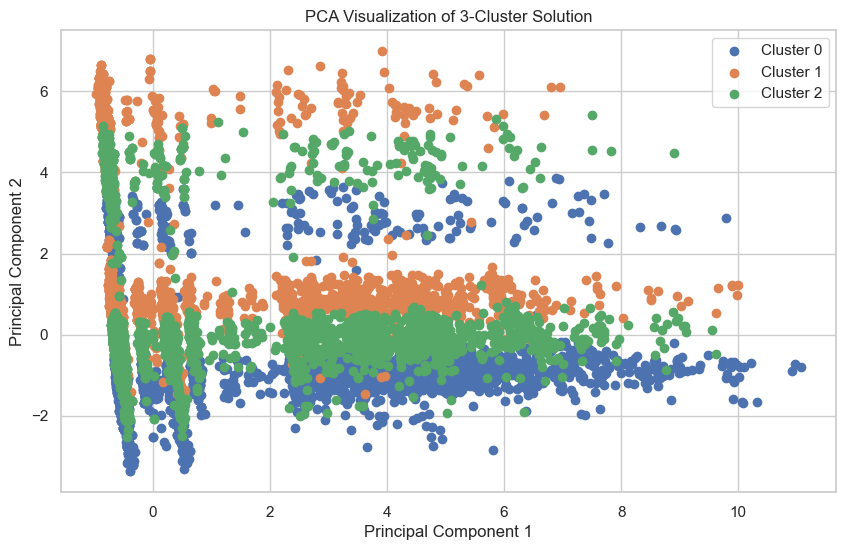

In [45]:
# Set up the figure
plt.figure(figsize=(10, 6))

# Scatter plot for each cluster
for cluster_id in range(3):
    cluster_data = pca_df[pca_df['Cluster'] == cluster_id]
    plt.scatter(cluster_data['PC1'], cluster_data['PC2'], label=f'Cluster {cluster_id}')

# Add labels, title, and legend
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Visualization of 3-Cluster Solution')
plt.legend()

# Show the plot
plt.show()

In [63]:
# Fit KMeans with 3 clusters (or your chosen number of clusters)
kmeans_3 = KMeans(n_clusters=3, random_state=42)
cluster_labels_3 = kmeans_3.fit_predict(scaled_numerical_data)

# Add the cluster labels as a new column in the data_copy DataFrame
data_copy['cluster'] = cluster_labels_3

C:\Users\ashka\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [65]:
# Standardize the numerical data for clustering
scaler = StandardScaler()
scaled_numerical_data = scaler.fit_transform(numerical_data)

# Fit KMeans with 3 clusters (or your chosen number of clusters)
kmeans_3 = KMeans(n_clusters=3, random_state=42)
cluster_labels_3 = kmeans_3.fit_predict(scaled_numerical_data)

# Add the cluster labels as a new column in the data_copy DataFrame
data_copy['cluster'] = cluster_labels_3

# Calculate cluster means
cluster_means = data_copy.groupby('cluster')[numerical_features].mean()

# Display cluster distribution
cluster_distribution = data_copy['cluster'].value_counts().sort_index()
print(cluster_distribution)
print(cluster_means)

cluster
0     2705
1    23526
2     2906
Name: count, dtype: int64
         flight_discount_amount  hotel_discount_amount  page_clicks     seats  \
cluster                                                                         
0                      0.007967               0.007523    26.077264  2.000000   
1                      0.006958               0.006586    26.685114  1.000468   
2                      0.038575               0.007467    26.644529  1.048864   

         checked_bags  base_fare_usd    nights     rooms  hotel_per_room_usd  \
cluster                                                                        
0            0.563771     702.476695  2.559704  1.992976          170.355638   
1            0.548585     352.486669  2.527757  1.000000          168.977514   
2            0.543359     370.759594  2.597729  1.046456          168.104611   

         session_count  discount_flight_proportion  average_flight_discount  \
cluster                                        

C:\Users\ashka\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


# At this point I am going back to SQL to modify and re-engineer some features for an easier, and probably less accurate analysis.